In [1]:
#this is a test commit edit

In [1]:
print('hello world')

hello world


In [4]:
# INSTALLATIONS

!pip install rasterio

     |████████████████████████████████| 18.1 MB 24.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [6]:
!pip install imgaug

     |████████████████████████████████| 948 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 97.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [7]:
import numpy as np
import numpy.ma as ma
import rasterio
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
import imgaug as ia
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from imgaug import augmenters as iaa

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
)
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    UpSampling2D,
    MaxPooling2D,
    Dropout,
    concatenate,
    Conv2DTranspose,
    BatchNormalization,
    Flatten
)

ia.seed(2)


In [8]:
# configuration variables
input_size = 256
n_channels = 6
model_save_path = 'test_model.h5'

In [28]:
class UnetGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, data_path,
                 to_fit=True, batch_size=1, dim=(256, 256),
                 n_channels=6, shuffle=True, augment=True):
        'Initialization'
        self.data_path = data_path
        self.tif_list = []
        self.mask_list = []
        for filename in glob(f'{data_path}*.tif*'):
            self.tif_list.append(filename)

        self.to_fit = to_fit
        self.augment = augment
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.n = 0
        self.max = self.__len__()
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.tif_list) / self.batch_size))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.tif_list))
        if self.shuffle is True:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index *
                               self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        tif_list_temp = [self.tif_list[k] for k in indexes]

        # Generate data
        X = self._generate_X(tif_list_temp)

        #  preprocess and augment data

        if self.to_fit:
            y = self._generate_y(tif_list_temp)

            if self.augment:
                seq = make_augmentations()
                images_aug = list()
                labels_aug = list()
                for i in range(len(X)):
                    image, label = seq(
                        image=X[i].astype('float32'),
                        segmentation_maps=np.expand_dims(
                            y[i], 0).astype('uint8')
                    )
                    images_aug.append(image)
                    labels_aug.append(label[0, :, :, :])

                return np.array(images_aug), np.array(labels_aug)
            else:
                # import ipdb; ipdb.set_trace()
                return X, y[:,:,:,0]

        else:
            return X

    def _generate_X(self, tif_list_temp):
        'Generates data containing batch_size images'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(tif_list_temp):
            # Store sample
            X[i, ] = _load_tif_image(ID, self.dim)
#         print(X)
        return X

    def _generate_y(self, tif_list_temp):
        'Generates data containing batch_size masks'
        y = np.empty((self.batch_size, *self.dim, 1), dtype='float32')

        # Generate data
        for i, ID in enumerate(tif_list_temp):
            # replace tif/tiff with the _bitmap.png or .bmp, depending on the dataset
            # to look for corresponding masks for the imput images
            y[i, ] = _load_grayscale_image(ID.replace(
                '.tif', '.bmp'), self.dim
            )
#         print(y)
        return y

    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result


def _load_grayscale_image(image_path, dim):
    'Load grayscale image'
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255

    return np.expand_dims(cv2.resize(img, dim), -1)
#     return cv2.resize(img, dim)


def _load_tif_image(image_path, dim):
    'load tif image'

    with rasterio.open(image_path, 'r') as data:
#         return cv2.resize(
#             np.moveaxis(data.read(), 0, -1), dim
#         )
        return cv2.resize(
                    np.moveaxis(data.read(), 0, -1), dim
                )


def sometimes(aug):
    return iaa.Sometimes(0.5, aug)

def make_augmentations():

    return iaa.Sequential([
        sometimes(iaa.CoarseDropout(0.1, size_percent=0.2)),
        sometimes(
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                # scale images to 80-120% of their size,
                # individually per axis
                translate_percent={
                    "x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                # translate by -20 to +20 percent (per axis)
                # rotate by -45 to +45 degrees
                rotate=(-10, 10),
                shear=(-5, 5),  # shear by -16 to +16 degrees
            ),
        ),
        sometimes(iaa.ElasticTransformation(alpha=10, sigma=1))
    ],
        random_order=True
    )


In [10]:
num_layers = 2
input_shape = (input_size, input_size, 6)
inputs = Input(input_shape)

def bn_conv_relu(input, filters, bachnorm_momentum, **conv2d_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2D(filters, **conv2d_args)(x)
    return x


def bn_upconv_relu(input, filters, bachnorm_momentum, **conv2d_trans_args):
    x = BatchNormalization(momentum=bachnorm_momentum)(input)
    x = Conv2DTranspose(filters, **conv2d_trans_args)(x)
    return x

filters = 24
upconv_filters = 32

kernel_size = (3, 3)
activation = 'relu'
strides = (1, 1)
padding = 'same'
kernel_initializer = 'he_normal'
output_activation = 'sigmoid'

conv2d_args = {
    'kernel_size': kernel_size,
    'activation': activation,
    'strides': strides,
    'padding': padding,
    'kernel_initializer': kernel_initializer
}

conv2d_trans_args = {
    'kernel_size': kernel_size,
    'activation': activation,
    'strides': (2, 2),
    'padding': padding,
}

bachnorm_momentum = 0.01

pool_size = (2, 2)
pool_strides = (2, 2)
pool_padding = 'valid'

maxpool2d_args = {
    'pool_size': pool_size,
    'strides': pool_strides,
    'padding': pool_padding,
}

x = Conv2D(filters, **conv2d_args)(inputs)
c1 = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
x = bn_conv_relu(c1, filters, bachnorm_momentum, **conv2d_args)
x = MaxPooling2D(**maxpool2d_args)(x)

down_layers = []

for l in range(num_layers):
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    down_layers.append(x)
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = MaxPooling2D(**maxpool2d_args)(x)

x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
x = bn_upconv_relu(x, filters, bachnorm_momentum, **conv2d_trans_args)

for conv in reversed(down_layers):
    x = concatenate([x, conv])
    x = bn_conv_relu(
        x, upconv_filters, bachnorm_momentum, **conv2d_args
    )
    x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)
    x = bn_upconv_relu(
        x, filters, bachnorm_momentum, **conv2d_trans_args
    )

x = concatenate([x, c1])
x = bn_conv_relu(x, upconv_filters, bachnorm_momentum, **conv2d_args)
x = bn_conv_relu(x, filters, bachnorm_momentum, **conv2d_args)

outputs = Conv2D(
    1,
    kernel_size=(1, 1),
    strides=(1, 1),
    activation=output_activation,
    padding='valid')(x)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 24) 1320        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 24) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 24) 5208        batch_normalization[0][0]        
_____________

In [50]:
class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        #print
        print()
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.set_ylim([0,1])
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show()

pl = PlotLearning()
callbacks = [
    EarlyStopping(monitor="val_loss", patience=20,
                  verbose=1, mode="auto"),
    ModelCheckpoint(filepath=model_save_path,
                    verbose=1, save_best_only=True),
    pl,
]


In [51]:
model.compile(
    optimizer=Adam(
                learning_rate=0.0001,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
            ),
    loss='binary_crossentropy',
    metrics=["accuracy"]
)


In [52]:
#Data splits
# import splitfolders

# splitfolders.ratio("data/input/", output="data/output/", seed=1337, ratio=(.8, .2), group_prefix=2) 

In [53]:
train_generator = UnetGenerator('data/output/train/class1/', batch_size=4)
val_generator = UnetGenerator('data/output/val/class1/', batch_size=4)

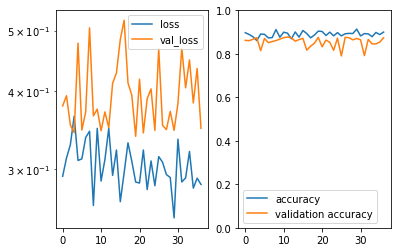

13/13 [==============================] - 9s 719ms/step - loss: 0.2839 - acc: 0.9000 - val_loss: 0.3490 - val_acc: 0.8738
Epoch 38/100
 3/13 [=====>........................] - ETA: 4s - loss: 0.2386 - acc: 0.9149

In [ ]:
results = model.fit_generator(
    train_generator,
    epochs=100,
    steps_per_epoch=13,
    validation_data=val_generator,
    callbacks=callbacks,
    validation_steps=10,
    verbose=1
)

In [49]:
results.history

{'loss': [0.3543541064629188,
  0.34507710658586943,
  0.3756613525060507,
  0.3222777465215096,
  0.2936439227599364],
 'acc': [0.87137663, 0.88255954, 0.86171544, 0.8900563, 0.9028159],
 'val_loss': [0.326740974187851,
  0.3228807389736176,
  0.3619023710489273,
  0.5103609234094619,
  0.33549797981977464],
 'val_acc': [0.89194757, 0.8995644, 0.8861958, 0.8762253, 0.89835626]}

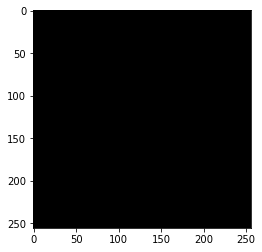

In [20]:
obj = train_generator.__getitem__(0)
xs = obj[0]
img= xs[0]
img.shape
plt.imshow(img)

{1: 'uint8', 2: 'uint8', 3: 'uint8', 4: 'uint8', 5: 'uint8', 6: 'uint8'}
BoundingBox(left=-102.0, bottom=35.2, right=-97.2, top=39.5)
(256, 256)


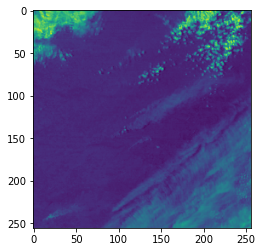

In [11]:
''' for .tif images'''

image_path = 'data/output/train/class1/time-20170652036101-loc--102.0_35.2_-97.2_39.5.tif'
dim = train_generator.dim
# print(dim)
with rasterio.open(image_path, 'r') as data:

#     d = {i: dtype for i, dtype in zip(data.indexes, data.dtypes)}
#     print(d)
    
#     img = cv2.resize(
#         np.moveaxis(data.read(), 0, -1), dim
#     )
    img = cv2.resize(data.read(1), dim)
    
    print(img.shape)
    plt.imshow(img)

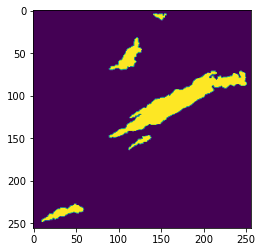

In [18]:
''' for .bmp images'''

image_path = 'data/output/train/class1/time-20170652036101-loc--102.0_35.2_-97.2_39.5.bmp'
dim = train_generator.dim
# print(dim)
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img / 255

# img = np.expand_dims(cv2.resize(img, dim), -1)
plt.imshow(cv2.resize(img, dim))


#     return np.expand_dims(cv2.resize(img, dim), -1)